# Introduction
Visualizing the paths of 

- GD on Client data
- GD on accumulated distribution ( with gradient descent )
- FedAvg ( with gradient descent )


## Table of Contents:
* [**Part 1**: Create non-iid client distributions](#ref1)
* [**Part 2**. Apply gradient descent for one client](#ref2)
* [2.1 Right on track: gradient descent ftw!](#ref2.1)
* [2.2 Taking the detour: an intro to gradient descent in python](#ref2.2)
* [**Part 3**:Gradient descent for both clients and the global distribution](#ref3)
* [**Part 4**: FedAvg with non-iid client data](#ref4)
* [4.1 Taking the detour: An intro to FedAvg](#ref4.1)
* [4.2 Back on track: Federated Averaging](#ref4.2)
* [4.3 How to mess with Federated Averaging](#ref4.3)
* [**Part 5**: Optional: further plots and experiments ](#ref5)

In [15]:
# import some utilities
from computation_fedavg_gd import grad_descent, partial_derivative
from computation_fedavg_gd import MultivarianteGaussian

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## **Part 1**: Create non-iid client distributions <a class="anchor" id="ref1"></a>
### Multivariante Gaussians: Draw the client distributions over our model weights / over theta 

Think about the following scenario: 

You (client 1) have personal images on your smartphone. So do your friends (client 2,..,n). Your goal is to create a machine learning model, which does a good job at the classification of the images from your phone and also the images from your friends. 

In the past (before 2017), the common approach was, that everyone uploads their images to some kind of central server, the images get aggregated, and you train a model.

The introduction of FedAvg enables us know, to train a model without uploading any images to any kind of central server. Isn't that great!?! But how does it work?


First step: lets pick two client distributions. The distributions symbolize the weights of your model, which we try to optimize. For this notebook, lets assume your model has 2 tunable parameters theta, and there is 2 clients. If we tune our parameters, lets assume that our goal function which we try to maximize, has a Gaussian distribution.

The Multivariante Gaussian is defined in ```computation_fedavg_gd.py```. 

View it by running:
```
import inspect
print(inspect.getsource(MultivarianteGaussian))
```
or just
```
MultivarianteGaussian??
```

In [54]:
multivariante1 = MultivarianteGaussian(
    mu=np.array([0, 1]), sigma=np.array([[1.0, -0.9], [-0.5, 1.5]])
)
multivariante2 = MultivarianteGaussian(
    np.array([0, -1.2]), sigma=np.array([[1.5, 0.6], [0.9, 1.0]])
)
## MultivarianteGaussian??

In [17]:
# calculate at our target function over a sampling grid
from plot_fedavg_gd import SAMPLE_GRID_VECTOR, Z
Z1 = multivariante1.evaluate(theta_vec=SAMPLE_GRID_VECTOR)
Z2 = multivariante2.evaluate(theta_vec=SAMPLE_GRID_VECTOR)
print(f"evaluated gaussian over a 2D sampling grid {SAMPLE_GRID_VECTOR.shape} for a 3D target vector {Z1.shape}")

evaluated gaussian over a 2D sampling grid (71, 71, 2) for a 3D target vector (71, 71)


alright, lets make some fancy visualizations of our client 1 distribution

<IPython.core.display.Javascript object>


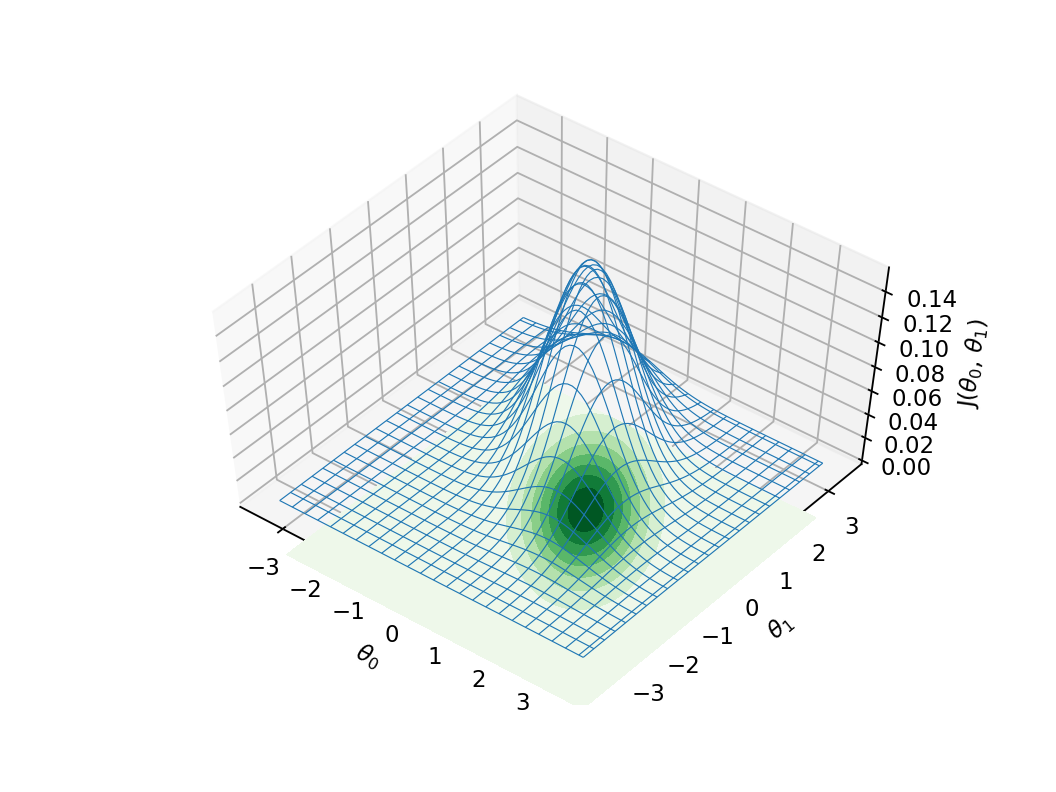

<IPython.core.display.Javascript object>


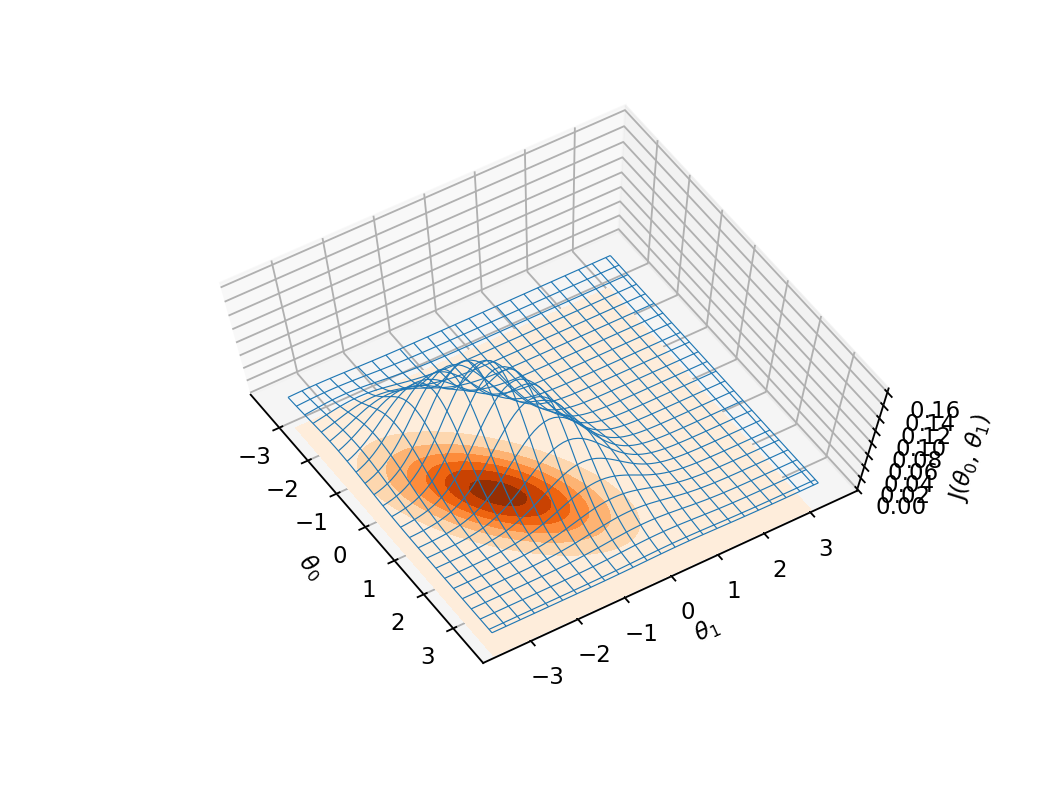

In [45]:
%matplotlib notebook 

# lets visualize our distributions

def client_function_draw(eval_sample, cmap = matplotlib.cm.Greens):
    # some 3D settings
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.set_xlabel(r"${\theta}_0$", zorder = 1)
    ax.set_ylabel(r"${\theta}_1$", zorder = 1)
    ax.set_zlabel(r"J(${\theta}_0$, ${\theta}_1$)", zorder = 1)

    # plot a 3D curve
    ax.plot_wireframe(
        SAMPLE_GRID_VECTOR[:,:,0],
        SAMPLE_GRID_VECTOR[:,:,1],
        eval_sample,
        rstride=3,
        cstride=3,
        linewidth=0.5,
        antialiased=True,
        cmap=matplotlib.cm.Greens,
        label="client 1 target",
        zorder=1,
    )
    # make a 2D Countour plot in green on the bottom
    ax.contourf(
        SAMPLE_GRID_VECTOR[:,:,0],
        SAMPLE_GRID_VECTOR[:,:,1],
        eval_sample,
        zdir="z",
        offset=-0.05,
        cmap=cmap,
        zorder=0,
    )
    return ax
fig = client_function_draw(Z1)
fig = client_function_draw(Z2, cmap="Oranges")

## **Part 2**. Apply gradient descent for one client <a class="anchor" id="ref2"></a>


### 2.1 Right on track: gradient descent ftw! <a class="anchor" id="ref2.1"></a>
Let's see how this would look like, with Gradient Descent applied. If you want to see how GD works, look [below](#ref2.2).

iter: 20, theta0: -1.90, theta1: 0.135, gradient: 5.851644834070548e-05
iter: 40, theta0: -1.78, theta1: 0.183, gradient: 0.00012030952797817407
iter: 60, theta0: -1.61, theta1: 0.256, gradient: 0.00029321539987694524
iter: 80, theta0: -1.37, theta1: 0.375, gradient: 0.0008646377314871119
iter: 100, theta0: -1.01, theta1: 0.578, gradient: 0.002478085102418169
iter: 120, theta0: -0.60, theta1: 0.842, gradient: 0.0027783703576439445
iter: 140, theta0: -0.31, theta1: 1.016, gradient: 0.0008270639842299921
iter: 160, theta0: -0.17, theta1: 1.076, gradient: 0.00016233945655244608
iter: 180, theta0: -0.11, theta1: 1.084, gradient: 3.89347381805627e-05
iter: 200, theta0: -0.07, theta1: 1.075, gradient: 1.43771937393955e-05
iter: 220, theta0: -0.05, theta1: 1.061, gradient: 7.246760000662045e-06
iter: 240, theta0: -0.04, theta1: 1.049, gradient: 4.119632822013886e-06
iter: 260, theta0: -0.03, theta1: 1.038, gradient: 2.424153120739181e-06
iter: 280, theta0: -0.02, theta1: 1.029, gradient: 1.43

<IPython.core.display.Javascript object>


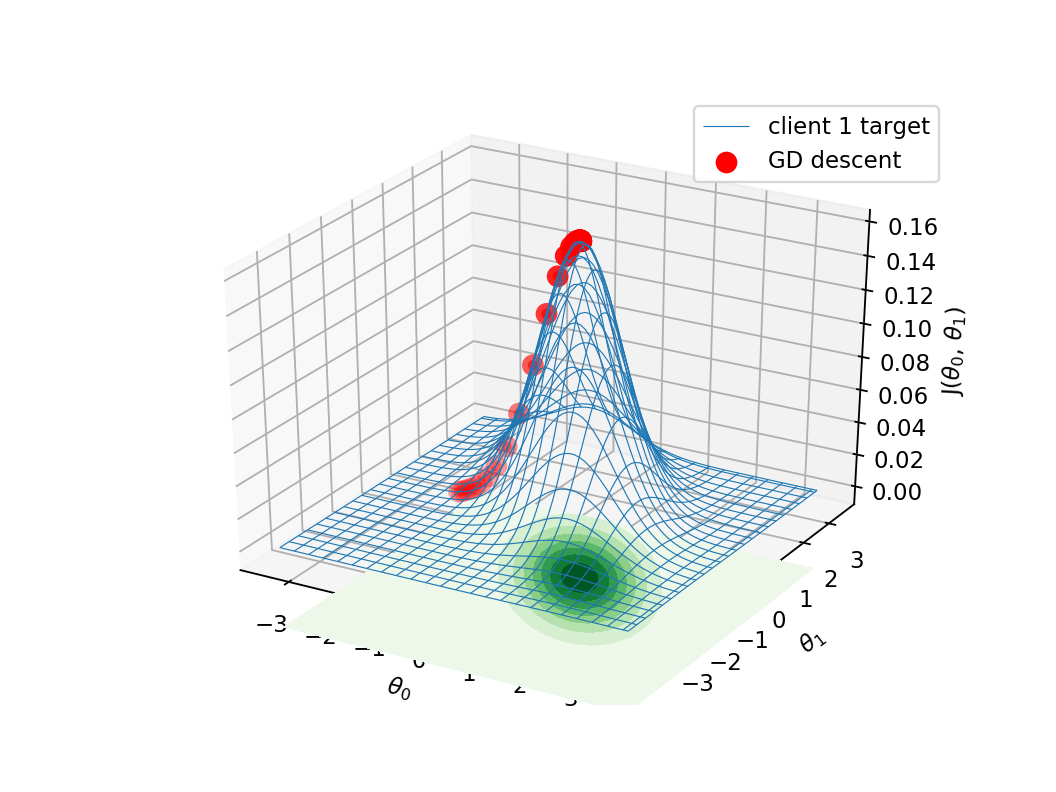

In [19]:
%matplotlib notebook 

THETA0 =-2.0
THETA1 =0.1
history = grad_descent(
    function_descent=multivariante1.evaluate,
    theta0=THETA0,
    theta1=THETA1,
    eps=1e-07,  # stop condition
    nb_max_iter=1000,  # max iterations,
    verbose=1,
)
ax = client_function_draw(Z1)

ax.scatter(
    history[:, 0][::10],
    history[:, 1][::10],
    history[:, 2][::10],
    label="GD descent",
    c="red",
    lw=5,
    zorder=100,
)
fig = ax.legend()

Awesome. If you are interested how gradient descent works, check out the file ```computation_fedavg_gd.py``` in this repository. You can also check out this code at the below, for your convinience.

## 2.2  Taking the detour: an intro to gradient descent in python<a class="anchor" id="ref2.2"></a>


Below, you can see how gradient decent is implemented. 

In [52]:
print("# Usage of line-search: optimize one parameter at a time")
partial_derivative??

# Usage of line-search: optimize one parameter at a time


In [48]:
print("# Evaluating gradient descent for one function:")
grad_descent??


## **Part 3**:Gradient descent for both clients and the global distribution <a class="anchor" id="ref3"></a>
### Lets add two functions client1 + client2 together!
draw global distribution (add both )

In [21]:
def f_added_tutorial(theta0: float = None, theta1: float = None, theta_vec: float = None):
    """adds the output of the two client distributions"""
    if theta_vec is not None and theta0 is None and theta1 is None:
        pos = theta_vec
    elif theta_vec is None and theta0 is not None and theta1 is not None:
        pos = np.array((theta0, theta1))
    else:
        raise BaseException("either set a theta0/theta0 or theta_vec")
    # expects vectorized input
    # return == multivariante1 + multivariante2
    return multivariante1.evaluate(theta_vec = pos) + multivariante2.evaluate(theta_vec = pos)


client 1
create 3D plot using SGD on [('GD client 1', 'green')]over distribution ['client 1 target']


<IPython.core.display.Javascript object>


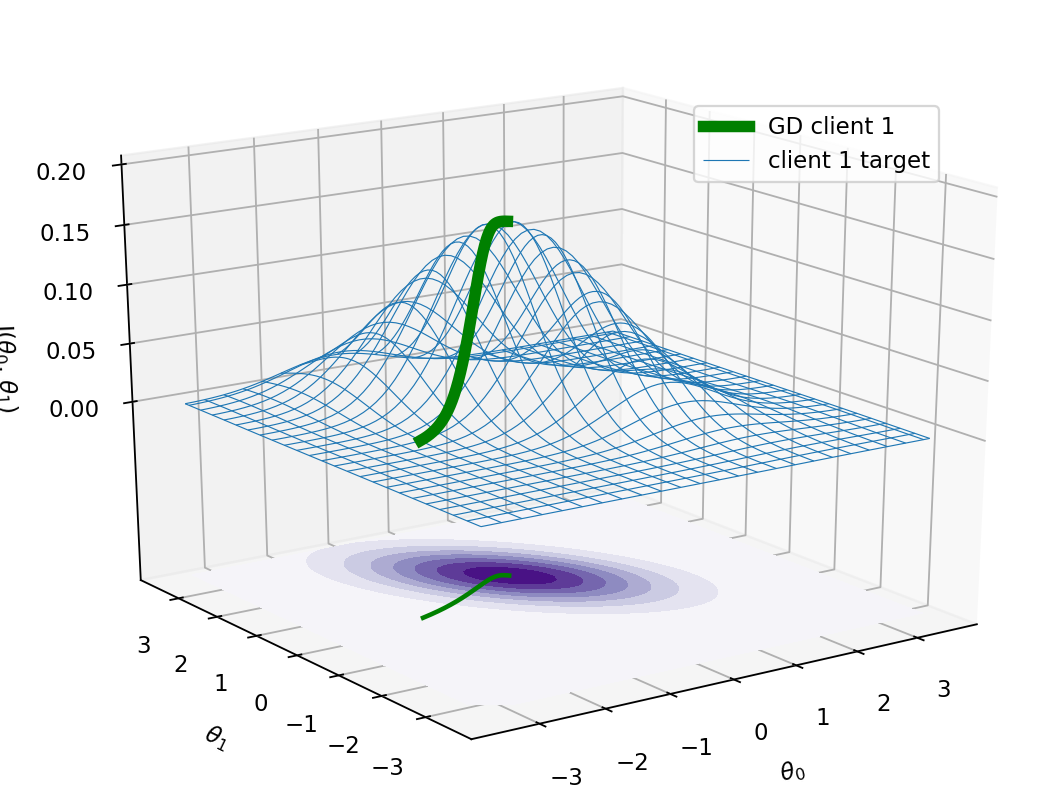

client 2
create 3D plot using SGD on [('GD client 2', 'orange')]over distribution ['client 2 target']


<IPython.core.display.Javascript object>


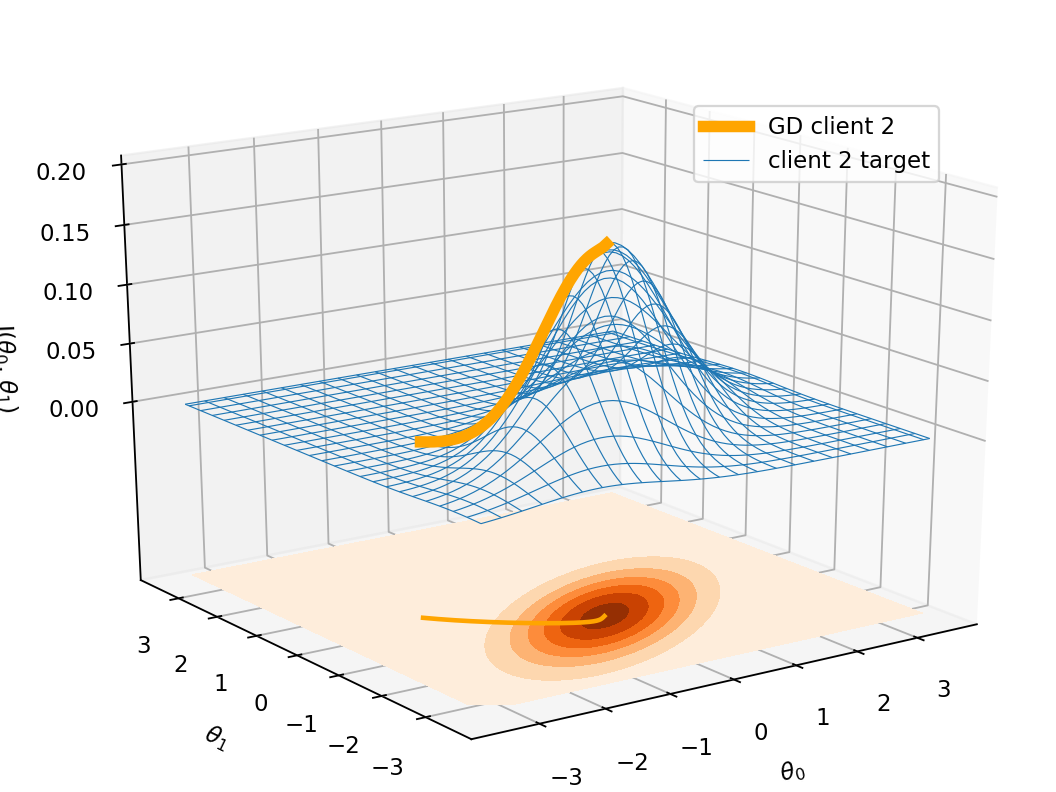

In [22]:
from plot_fedavg_gd import mpl_multivariante_3d_gd
print("client 1")
fig = mpl_multivariante_3d_gd(
    name_labels=[ "GD client 1"],
    colors=[ "green"],
    functions=[ multivariante1.evaluate],
    target_function=[ Z1],
    cmap_target=[ "Purples"],
    label_target=[ "client 1 target"],
    theta0=THETA0,
    theta1=THETA1,
)
print("client 2")
fig = mpl_multivariante_3d_gd(
    name_labels=["GD client 2", ],
    colors=["orange", ],
    functions=[multivariante2.evaluate, ],
    target_function=[Z2],
    cmap_target=["Oranges", ],
    label_target=["client 2 target", ],
    theta0=THETA0,
    theta1=THETA1,
)

create 3D plot using SGD on [('GD client 1&2', 'purple'), ('GD client 2', 'orange'), ('GD client 1', 'green')]over distribution ['global target']


<IPython.core.display.Javascript object>


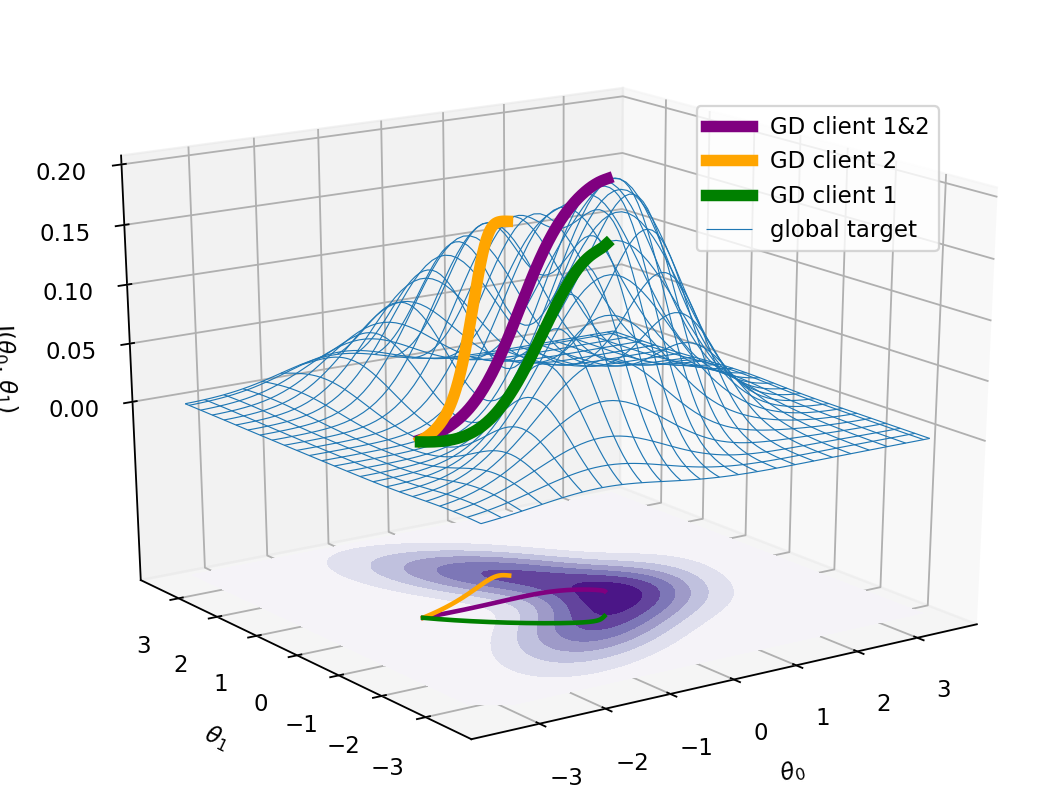

In [23]:
#lets do, as if we could aggregate our global function
fig = mpl_multivariante_3d_gd(
        name_labels=["GD client 1&2", "GD client 2", "GD client 1"],
        colors=["purple", "orange", "green"],
        functions=[f_added_tutorial, multivariante1.evaluate, multivariante2.evaluate],
        target_function=[Z],
        cmap_target=["Purples"],
        label_target=["global target"],
        theta0=THETA0,
        theta1=THETA1,
    )

# **Part 4**: FedAvg with non-iid client data<a class="anchor" id="ref4"></a>


## 4.1 Taking the detour: An intro to FedAvg <a class="anchor" id="ref4.1"></a>
FedAvg basically works like this:
```
theta = [theta0, theta1]
nb_rounds = 10
gd_steps_local = 20


def client_update(theta):
    """on the clients"""
    
    client_data = client.get_distribution() # get the client data
    
    # update the parameters
    for i in range(gd_steps_local):
        theta = grad_descent(client_data, theta, nb_steps=1)
    
    # send back the most recent model
    return theta
    
def fedavg_server_update(theta_0):
    """on the server"""
    theta_current = theta_0
    
    for i in range(nb_rounds):
        # in parallel
        theta_client1 = client1.client_update(theta_current)
        theta_client2 = client2.client_update(theta_current)  
        
        theta_current = average(theta_client1, theta_client2)
    
    # output best model at the end of training
    return theta_current 
```


In [55]:
# optional, get the source code 


from computation_fedavg_gd import fedavg
print("# FedAvg implementation \n")
fedavg??
#import inspect
#print(inspect.getsource(fedavg))

# FedAvg implementation 



## 4.2 Back on track: Federated Averaging <a class="anchor" id="ref4.2"></a>


<IPython.core.display.Javascript object>


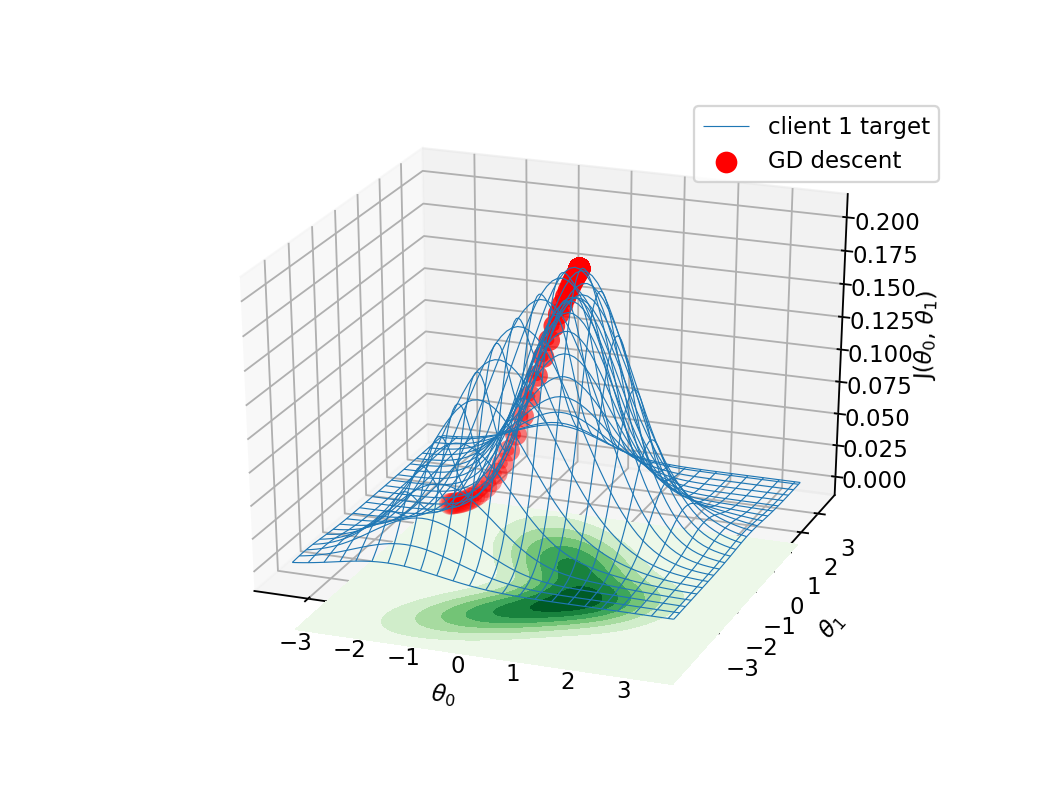

In [25]:
from computation_fedavg_gd import fedavg as fedavg_server_update

history , _, _ = fedavg_server_update(
    function_descent_1=multivariante1.evaluate, # client 1
    function_descent_2=multivariante2.evaluate, # client 2
    function_eval=f_added_tutorial,    # evaluation function on the server 
    communication_rounds = 500,
    gd_steps_local = 10,
    theta0=THETA0,
    theta1=THETA1,
)

ax = client_function_draw(Z)

ax.scatter(
    history[:, 0],
    history[:, 1],
    history[:, 2],
    label="GD descent",
    c="red",
    lw=5,
    zorder=100,
)
ax.legend()

### Congratiulations! You made it. FedAvg reaches the global optimum. But.. is that really true?
## 4.3 How to mess with Federated Averaging <a class="anchor" id="ref4.3"></a>



<IPython.core.display.Javascript object>


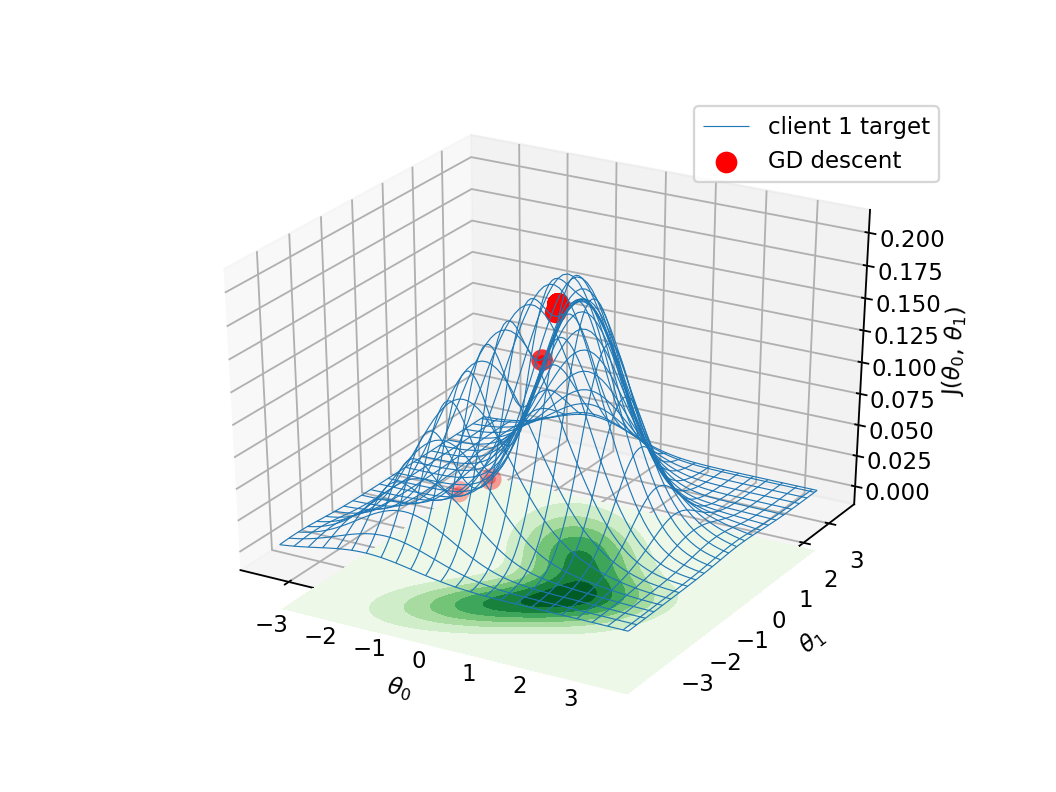

In [32]:
history , _, _ = fedavg_server_update(
    function_descent_1=multivariante1.evaluate, # client 1
    function_descent_2=multivariante2.evaluate, # client 2
    function_eval=f_added_tutorial,    # evaluation function on the server 
    communication_rounds = 20,
    gd_steps_local = 100,
    theta0=THETA0,
    theta1=THETA1,
)

ax = client_function_draw(Z)

ax.scatter(
    history[:, 0],
    history[:, 1],
    history[:, 2],
    label="GD descent",
    c="red",
    lw=5,
    zorder=100,
)
fig = ax.legend()


 If you would like to create more plots, find some below. 
 ## **Part 5**: Optional: further plots and experiments <a class="anchor" id="ref5"></a>

rounds 33, steps 95
create 3D plot using SGD on [('GD client 1&2', 'purple'), ('GD client 2', 'orange'), ('GD client 1', 'green')]over distribution ['accumulated targets (1&2)']


<IPython.core.display.Javascript object>


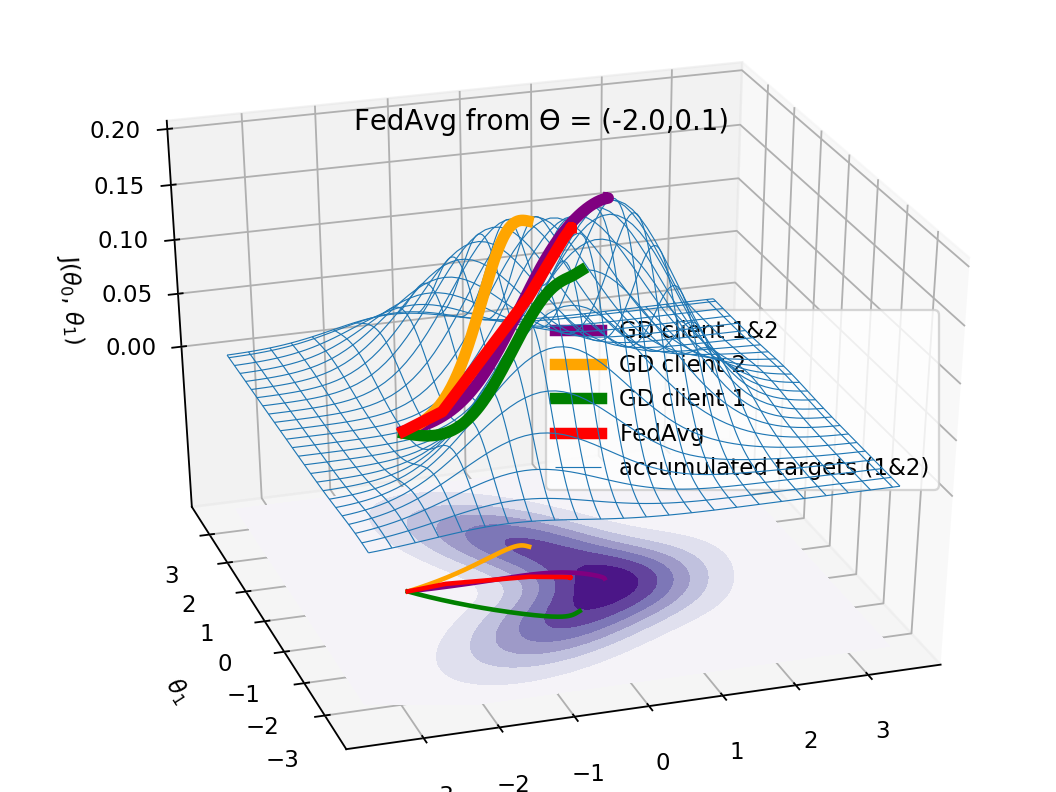

FedAvg from ϴ = (-2.0,0.1) [ 0.20869586 -0.13508129  0.17335261]


In [39]:
import random
rounds = random.randint(2,100)
steps = random.randint(1,20) * 5
print(f"rounds {rounds}, steps {steps}")

fig = mpl_multivariante_3d_gd(
    name_labels=["GD client 1&2", "GD client 2", "GD client 1"],
    colors=["purple", "orange", "green"],
    functions=[f_added_tutorial, multivariante1.evaluate, multivariante2.evaluate],
    target_function=[ Z],
    cmap_target=[ "Purples",],
    label_target=[ "accumulated targets (1&2)"],
    fedavg_1=multivariante1.evaluate,
    fedavg_2=multivariante2.evaluate,
    fedavg_eval=f_added_tutorial,
    fedavg_communication_rounds=rounds, 
    fedavg_steps_local=steps,
    title=f"FedAvg from \u03F4 = ({THETA0},{THETA1})",
    theta0=THETA0,
    theta1=THETA1,
)

# fig.savefig("name.svg") # for storing

In [13]:
# OPTIONAL: view the source code
import inspect

print("# Usage of line-search: optimize one parameter at a time: \n \n")
print(inspect.getsource(partial_derivative))

# Usage of line-search: optimize one parameter at a time: 
 

def partial_derivative(func, var=0, thetas=[]):
    """for line search in one-dim parameter space"""
    # credits https://moonbooks.org/Articles/How-to-implement-a-gradient-descent-in-python-to-find-a-local-minimum-/
    args = thetas[:]

    def wraps(x):
        """pick one of the thetas to optimize"""
        args[var] = x
        return func(*args)

    return misc.derivative(wraps, thetas[var])

